In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr


In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

# Loading SSH dataset from ECCO

In [5]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES
001 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_FRONT_FLUX
002 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_SHELF_FLUX
003 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X
004 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y
005 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X
006 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y
007 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X
008 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y
009 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX
010 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
011 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS
012 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_BOLUS_STREAMFUNCTION
013 /efs_ecco/ECCO/V4/r5/netc

In [6]:
# Select a dataset (the one containing SSH)
dataset_num = 27

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
TS_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in TS_dataset_files[:5]])


selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/SEA_SURFACE_HEIGHT

First 5 files
['SEA_SURFACE_HEIGHT_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'SEA_SURFACE_HEIGHT_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']


# METHOD 3: “REFERENCE” LOADING FILES STORED ON AWS S3
## PART 1: V4R4 FILES ON PODAAC
## Find files
Kerchunk files on ecco-model-granules s3 bucket

In [7]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [8]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [9]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_HEAT_FLUX_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/OCEAN_AND_ICE_SURFACE_STRESS_day_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/O

In [10]:
# MZZ files have been downloaded. 
# select the SSH dataset
mzz_local_file= mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_latlon_llc090_ECCOV4r5.json'
print(mzz_local_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/SEA_SURFACE_HEIGHT_mon_mean_latlon_llc090_ECCOV4r5.json


In [11]:
import fsspec
import zarr

In [12]:

fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds

<xarray.Dataset> Size: 1GB
Dimensions:         (time: 336, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    time_bnds       (time, nv) datetime64[ns] 5kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 348MB dask.array<chunksize=(4, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 348MB dask.array<chunksize=(4, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 348MB dask.array<chunksize=(4, 360, 720), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean 0.5 ...
    uuid:                         a9df9c04-2721-11f0-a7aa-0a58a9feac02

In [13]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)
SSH_all = ds.SSH
mean_SSH = ds.SSH.mean(dim='time').compute()

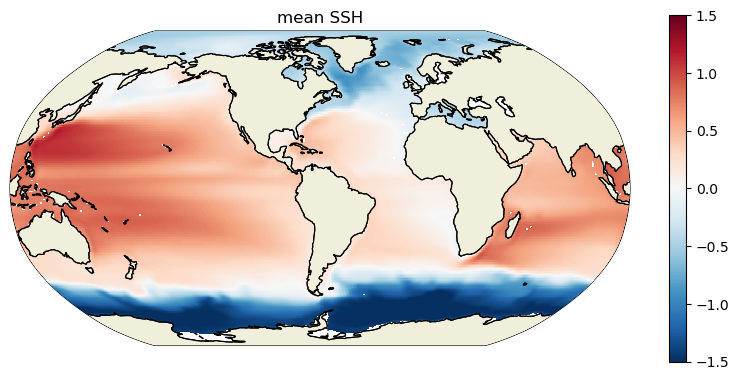

In [14]:
plt.figure(figsize=[10,4.5]);
ecco.plot_proj_to_latlon_grid(lon_mg, 
                              lat_mg, 
                              mean_SSH, 
                              user_lon_0=-67, 
                              show_colorbar=True,
                             cmin=-1.5, cmax=1.5)
plt.title(label="mean SSH");

# Selecting a particular region in the subpolar north Atlantic 

In [15]:
# # tweak as needed
# box_lat = np.logical_and(mean_SSH.latitude > -5, mean_SSH.latitude < 5)
# box_lon = np.logical_and(mean_SSH.longitude > -170, mean_SSH.longitude < -120)
# box = np.logical_and(box_lat, box_lon)

# # make mask, 1 in box, nan outside of box
# mask = np.where(box, 1, np.nan)

# Selecting data on tiles (native grid) format

In [16]:
# MZZ files have been downloaded. 
# select the SSH dataset
mzz_local_file2 = mzz_local_directory / 'SEA_SURFACE_HEIGHT_day_mean_native_llc090_ECCOV4r5.json'
print(mzz_local_file2)

/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native/SEA_SURFACE_HEIGHT_day_mean_native_llc090_ECCOV4r5.json


In [17]:

fs2 = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file2),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs2.asynchronous = True
store2 = zarr.storage.FsspecStore(fs2)
ds2 = xr.open_dataset(store2, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

ds2

<xarray.Dataset> Size: 17GB
Dimensions:    (time: 10226, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 82kB 1992-01-01T18:00:00 ... 2019-12-31
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 164kB dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    ETAN       (time, tile, j, i) float32 4GB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSH        (time, tile, j, i) float32 4GB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 4GB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 4GB dask.array<chunksize=(4, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Daily Mean llc90 ...
    uuid:                         a944285a-2721-11f0-8cbe-0a58a9feac02

In [18]:
SSH_extract = ds2.SSH.isel(time=1,tile=2)
SSH_extract

<xarray.DataArray 'SSH' (j: 90, i: 90)> Size: 32kB
dask.array<getitem, shape=(90, 90), dtype=float32, chunksize=(90, 90), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1992-01-02T12:00:00
    XC       (j, i) float32 32kB dask.array<chunksize=(90, 90), meta=np.ndarray>
    YC       (j, i) float32 32kB dask.array<chunksize=(90, 90), meta=np.ndarray>
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    tile     int32 4B 2
Attributes:
    comment:                Also known as ocean dynamic sea level.  The local...
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height
    units:                  m
    valid_max:              1.2782527208328247
    valid_min:              -1.8386059999465942

In [19]:
# Coordinate manipulations
# 16W-9E; 45N-65N

In [22]:
XC = SSH_extract.XC
YC = SSH_extract.YC

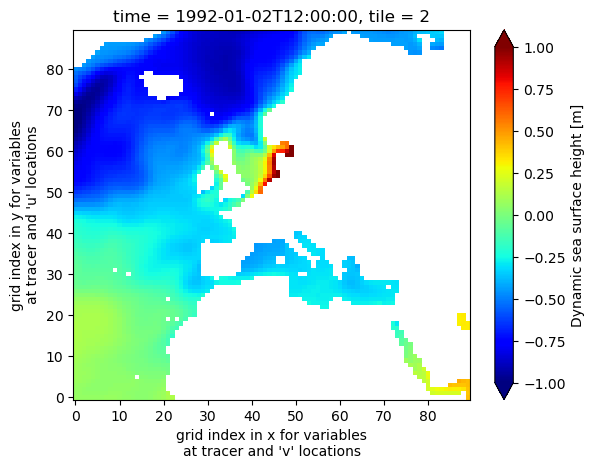

In [23]:
SSH_extract.plot(cmap='jet',vmin=-1, vmax=1)

In [24]:
# plt.figure(figsize=[10,4.5]);
# ecco.plot_proj_to_latlon_grid(XC, 
#                               YC, 
#                               SSH_extract, 
#                               user_lon_0=-67, 
#                               show_colorbar=True,
#                              cmin=-1.5, cmax=1.5)
# plt.title(label="mean SSH");

In [27]:
# help(ecco.plot_tiles)

In [28]:
# plot_tiles(tiles, 
#            cmap=None, 
#            layout='llc', 
#            rotate_to_latlon=False, 
#            Arctic_cap_tile_location=2, 
#            show_colorbar=False, 
#            show_cbar_label=False, 
#            show_tile_labels=True, 
#            cbar_label='', 
#            fig_size=9, 
#            less_output=True, 
#            **kwargs)

In [33]:
SSH_extract_mean = ds2.SSH.isel(tile=2).mean(dim=["i","j"])
SSH_extract_mean

<xarray.DataArray 'SSH' (time: 10226)> Size: 41kB
dask.array<mean_agg-aggregate, shape=(10226,), dtype=float32, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 82kB 1992-01-01T18:00:00 ... 2019-12-31
    tile     int32 4B 2

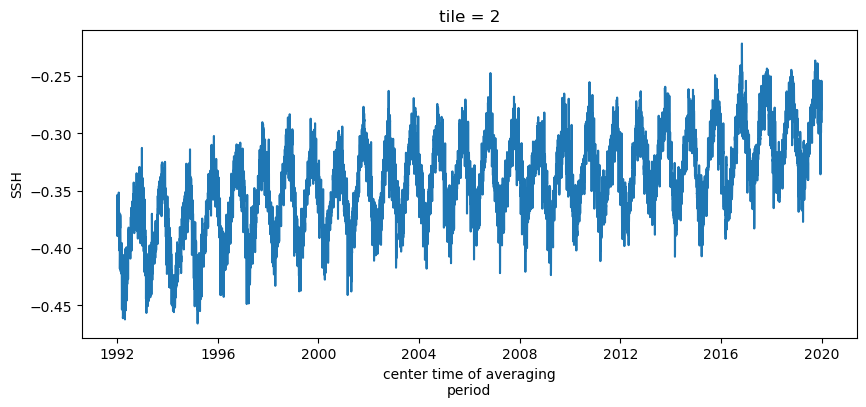

In [35]:
fig=plt.figure(figsize=[10,4])
SSH_extract_mean.plot()
plt.